In [1]:
# ! mkdir -p ./dataset
# ! curl -L -o ./dataset/archive.zip https://www.kaggle.com/api/v1/datasets/download/faizalkarim/flood-area-segmentation
# ! unzip -o ./dataset/archive.zip -d ./dataset
# ! rm ./dataset/archive.zip

In [2]:
%pip install torch torchvision matplotlib numpy pandas scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torchvision
import torch.nn.functional as F
import PIL
import os

from matplotlib import pyplot
from torch.optim.lr_scheduler import StepLR

class DoubleConv(torch.nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            torch.nn.BatchNorm2d(mid_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class UNet(torch.nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)


class Down(torch.nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = torch.nn.Sequential(
            torch.nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(torch.nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = torch.nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        x =  self.conv(x)

        x = torch.softmax(x, dim=1)
        return x


class OutConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [4]:
images = os.listdir('./dataset/Image/')
masks = os.listdir('./dataset/Mask/')

image_tensor = list()
mask_tensor = list()

for image in images:
    dd = PIL.Image.open(f'./dataset/Image/{image}')
    tt = torchvision.transforms.functional.pil_to_tensor(dd)
    tt = torchvision.transforms.functional.resize(tt, (100, 100))

    tt = tt[None, :, :, :]
    tt = torch.tensor(tt, dtype=torch.float) / 255.

    if tt.shape != (1, 3, 100, 100):
        continue

    mask = image.replace('.jpg', '.png')
    dd = PIL.Image.open(f'./dataset/Mask/{mask}')
    mm = torchvision.transforms.functional.pil_to_tensor(dd)
    mm = mm.repeat(3,1,1)
    mm = torchvision.transforms.functional.resize(mm, (100, 100))
    mm = mm[:1, :, :]

    mm = torch.tensor((mm > 0.).detach().numpy(), dtype=torch.long)
    mm = torch.nn.functional.one_hot(mm)
    mm = torch.permute(mm,(0, 3, 1, 2))
    mm = torch.tensor(mm, dtype=torch.float)

    image_tensor.append(tt)
    mask_tensor.append(mm)

image_tensor = torch.cat(image_tensor)
mask_tensor = torch.cat(mask_tensor)

print(image_tensor.shape, mask_tensor.shape)

print(image_tensor)
print(mask_tensor)

/tmp/ipykernel_4336/3015495467.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tt = torch.tensor(tt, dtype=torch.float) / 255.
/tmp/ipykernel_4336/3015495467.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mm = torch.tensor(mm, dtype=torch.float)


torch.Size([287, 3, 100, 100]) torch.Size([287, 2, 100, 100])
tensor([[[[0.5804, 0.7647, 0.7647,  ..., 0.3412, 0.3451, 0.3686],
          [0.4784, 0.5882, 0.6706,  ..., 0.3451, 0.3608, 0.3647],
          [0.3882, 0.5137, 0.6353,  ..., 0.3569, 0.4000, 0.4039],
          ...,
          [0.9608, 0.9608, 0.9686,  ..., 0.5647, 0.4706, 0.5373],
          [0.9529, 0.9569, 0.9608,  ..., 0.5686, 0.4980, 0.5137],
          [0.9451, 0.9451, 0.9490,  ..., 0.5333, 0.7765, 0.8118]],

         [[0.4549, 0.4863, 0.4941,  ..., 0.3608, 0.3608, 0.3765],
          [0.4510, 0.4667, 0.5569,  ..., 0.3608, 0.3725, 0.3647],
          [0.3725, 0.4706, 0.5922,  ..., 0.3451, 0.3804, 0.3922],
          ...,
          [0.7412, 0.7373, 0.7373,  ..., 0.5255, 0.4510, 0.4902],
          [0.7333, 0.7333, 0.7255,  ..., 0.5294, 0.4667, 0.4706],
          [0.7373, 0.7333, 0.7294,  ..., 0.4275, 0.6275, 0.6667]],

         [[0.3451, 0.4314, 0.4471,  ..., 0.2745, 0.2745, 0.2941],
          [0.3294, 0.3765, 0.4863,  ..., 0.278

In [5]:
unet = UNet(3, 2).to('cuda')

dataloader_train_image = torch.utils.data.DataLoader(image_tensor, batch_size=16)
dataloader_train_target = torch.utils.data.DataLoader(mask_tensor, batch_size=16)

optim = torch.optim.Adam(unet.parameters(), lr=0.01)
scheduler = StepLR(optim, step_size=1, gamma=0.5)
cross_entropy = torch.nn.CrossEntropyLoss()

loss_list = list()
jaccard_list = list()

for epoch in range(20):
    running_loss = 0.
    unet.train()

    jaccard_epoch = list()
    for image, target in zip(dataloader_train_image, dataloader_train_target):
        image = image.to('cuda')
        target = target.to('cuda')

        pred = unet(image)

        loss = cross_entropy(pred, target)
        
        running_loss += loss.item()

        loss.backward()
        optim.step()
        
    unet.eval()
    for image, target in zip(dataloader_train_image, dataloader_train_target):
        image = image.to('cuda')
        target = target.to('cuda')

        pred = unet(image)
        
        _, pred_unflatten = torch.max(pred, 1)
        _, target_unflatten = torch.max(target, 1)

        intersection = torch.sum(pred_unflatten == target_unflatten, dim=(1,2)) / 10000.
        jaccard_epoch.append(torch.mean(intersection).detach().to('cpu'))
    
    print(f'Epoch {epoch+1}',f'Loss: {running_loss}',f'Jaccard: {sum(jaccard_epoch) / len(jaccard_epoch)}')

    jaccard_list.append(sum(jaccard_epoch) / len(jaccard_epoch))

    loss_list.append(running_loss)    

    scheduler.step()




Epoch 1 Loss: 12.10789543390274 Jaccard: 0.6067124605178833
Epoch 2 Loss: 11.414180040359497 Jaccard: 0.7151235938072205
Epoch 3 Loss: 10.941388964653015 Jaccard: 0.5614637136459351
Epoch 4 Loss: 10.64507657289505 Jaccard: 0.7502284049987793
Epoch 5 Loss: 10.59892874956131 Jaccard: 0.7350012063980103
Epoch 6 Loss: 10.538922607898712 Jaccard: 0.7474777698516846
Epoch 7 Loss: 10.421857059001923 Jaccard: 0.7524188756942749
Epoch 8 Loss: 10.360949218273163 Jaccard: 0.7566657066345215
Epoch 9 Loss: 10.338767230510712 Jaccard: 0.7590014934539795
Epoch 10 Loss: 10.330362856388092 Jaccard: 0.7597687244415283
Epoch 11 Loss: 10.326178550720215 Jaccard: 0.7600088715553284
Epoch 12 Loss: 10.323802769184113 Jaccard: 0.7601115703582764
Epoch 13 Loss: 10.322449505329132 Jaccard: 0.7601989507675171
Epoch 14 Loss: 10.321702241897583 Jaccard: 0.7602379322052002
Epoch 15 Loss: 10.321301698684692 Jaccard: 0.7602666616439819
Epoch 16 Loss: 10.321092009544373 Jaccard: 0.7602772116661072
Epoch 17 Loss: 10.32

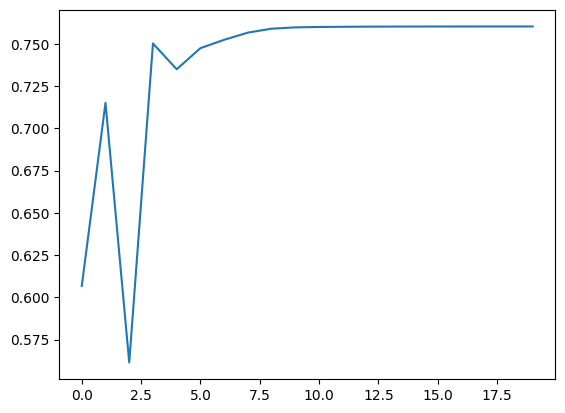

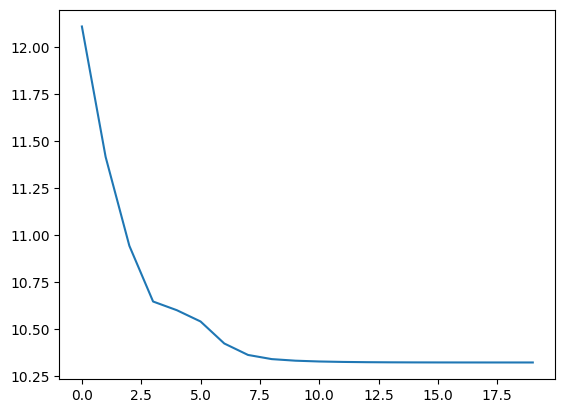

In [8]:
pyplot.plot(jaccard_list)
pyplot.savefig('jaccard_index.png')
pyplot.show()

pyplot.clf()
pyplot.plot(loss_list)
pyplot.savefig('loss.png')
pyplot.show()




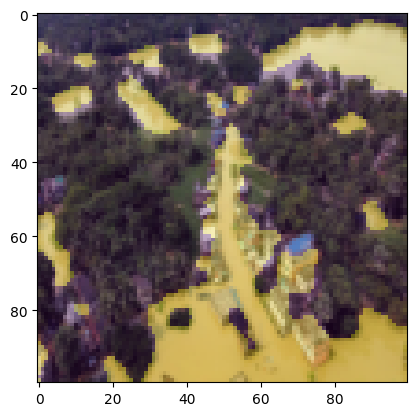

In [12]:
pyplot.clf()
pyplot.imshow(torch.permute(image[6].to('cpu'),(1,2,0)))
pyplot.imshow(pred_unflatten[6].to('cpu').detach().numpy(), alpha=0.3)
pyplot.savefig('mask.png')